In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
trainDf=pd.read_csv("train.csv")
print(trainDf.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [60]:
print(trainDf.shape)

(42000, 785)


In [61]:
ytrain=trainDf["label"].values
X_train=trainDf.iloc[:,1:].values.reshape(-1,28,28)
X_train=X_train.astype(np.float32)/255.0
print(f"Size of y_train : {len(ytrain)}\nSize of X_train : {X_train.shape}\n")

Size of y_train : 42000
Size of X_train : (42000, 28, 28)



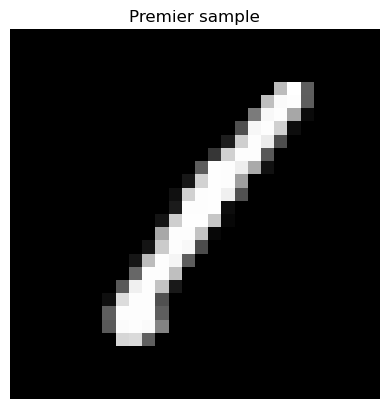

In [62]:
plt.imshow(X_train[0],cmap="gray")
plt.title("Premier sample")
plt.axis("off")
plt.show()

In [63]:
sobelX=np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]) #detection de bords horizontaux

sobelY=np.array([
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
]) #detection de bords verticaux

prewittX=np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
]) #detection de bords horizontaux (comme sobelX mais moins marqué)

laplacien=np.array([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]
]) #detection de bords toutes directions

laplacienPlus=np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
]) #detection de bords toutes directions (laplacien plus marqué)

blur=np.array([
    [1/9,1/9,1/9],
    [1/9,1/9,1/9],
    [1/9,1/9,1/9]
]) #flou

gaussien=np.array([
    [1/16,2/16,1/16],
    [2/16,4/16,2/16],
    [1/16,2/16,1/16]
]) #flou plus doux

sharpen=np.array([
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]
]) #accentuation contours


avrPooling2dKernel=np.array([
    [1/4,1/4],
    [1/4,1/4]
]) #Fait la moyenne des 4 éléments = avrPooling de dim 2,2

In [64]:
def padding(img,pad_size=0):
    if pad_size==0:
        return img
    else:
        newImg=np.zeros((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
        for w in range(pad_size,newImg.shape[0]-pad_size):
            for h in range(pad_size,newImg.shape[1]-pad_size):
                newImg[w][h]=img[w-pad_size][h-pad_size]
        return newImg

In [65]:
def createRandomKernels(nb_kernels,dim):
    kernels=[]
    for i in range(nb_kernels):
        kernels.append(np.random.randn(dim[0],dim[1]))
    return kernels

In [66]:
def maxPooling2d(images,dim):
    maxed=[]
    for img in images:
        newImg=np.zeros((((img.shape[0]-dim[0])//dim[0])+1,((img.shape[1]-dim[1])//dim[1])+1))
        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                cur_max=float("-inf")
                for kw in range(dim[0]):
                    for kh in range(dim[1]):
                        if img[w*dim[0]+kw][h*dim[1]+kh]>cur_max:
                            cur_max=img[w*dim[0]+kw][h*dim[1]+kh]
                newImg[w][h]=cur_max
        maxed.append(newImg)
    return maxed

In [67]:
def averagePooling2d(images,dim):
    averaged=[]
    for img in images:
        newImg=np.zeros((((img.shape[0]-dim[0])//dim[0])+1,((img.shape[1]-dim[1])//dim[1])+1))
        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                avr=0
                for kw in range(dim[0]):
                    for kh in range(dim[1]):
                        avr+=img[w*dim[0]+kw][h*dim[1]+kh]
                newImg[w][h]=avr/(dim[0]*dim[1])
        averaged.append(newImg)
    return averaged

In [68]:
def conv2d(inputs,out_dim,kernel_size,pad_size=0,stride=1,specificKernel=None,extractKernels=False):
    outputs=[]
    kernels=[]
    padded=[]
    for img in inputs:
        padded.append(padding(img,pad_size=pad_size))
    for resultante in range(out_dim):
        if specificKernel is not None:
            if len(specificKernel)!=len(inputs):
                if len(specificKernel)>len(inputs):
                    k=specificKernel[:len(inputs)]
                else:
                    k=specificKernel*(len(inputs)//len(specificKernel))+specificKernel[:len(inputs)%len(specificKernel)]
            else:
                k=specificKernel
        else:
            k=createRandomKernels(len(inputs),kernel_size)
        kernels.append(k)

        newImg=np.zeros((((padded[0].shape[0]-kernel_size[0])//stride)+1,((padded[0].shape[1]-kernel_size[1])//stride)+1))

        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                res=0
                for kw in range(kernel_size[0]):
                    for kh in range(kernel_size[1]):
                        tot=0
                        for i,img in enumerate(padded):
                            tot+=k[i][kw][kh]*img[w*stride+kw][h*stride+kh]
                        res+=tot
                newImg[w][h]=res

        outputs.append(newImg)
    
    if extractKernels:
        return outputs,kernels
    return outputs

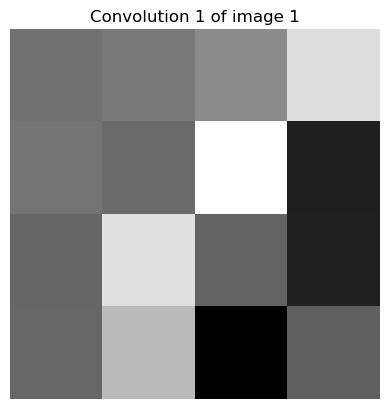

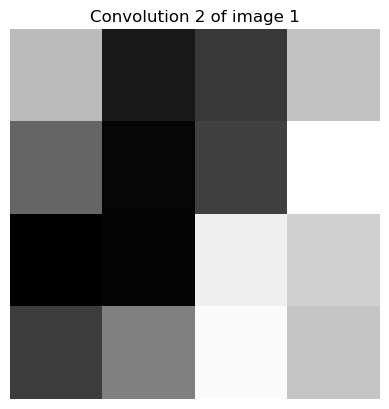

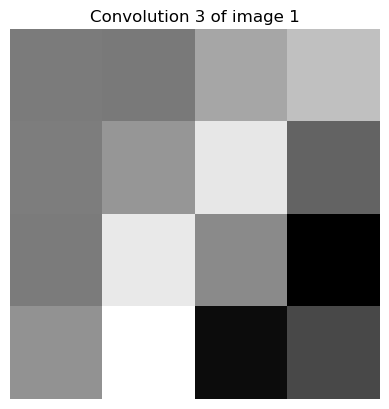

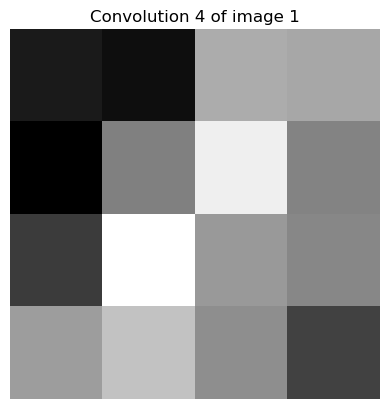

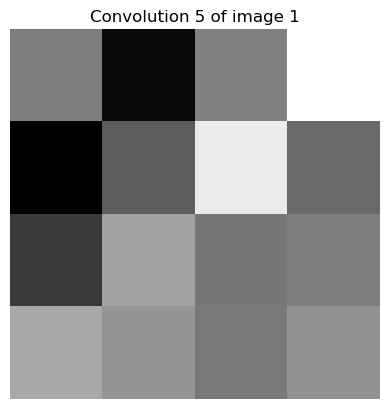

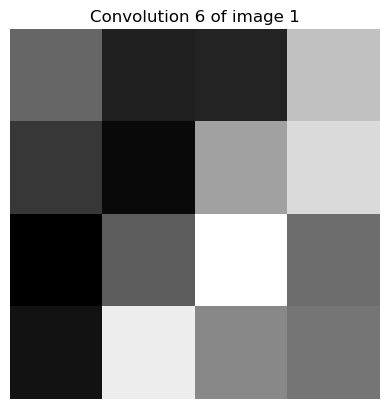

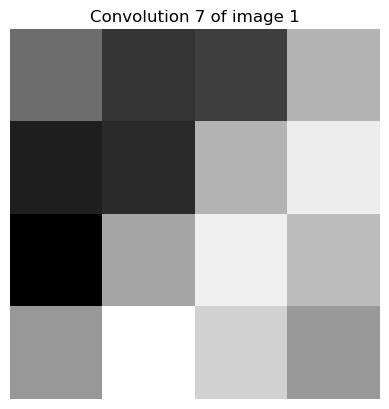

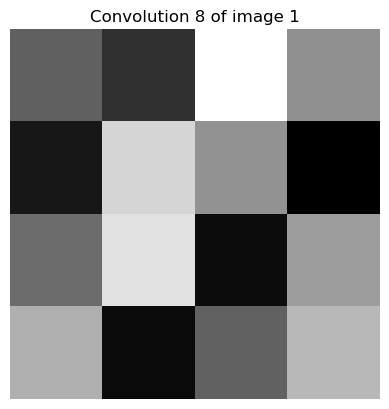

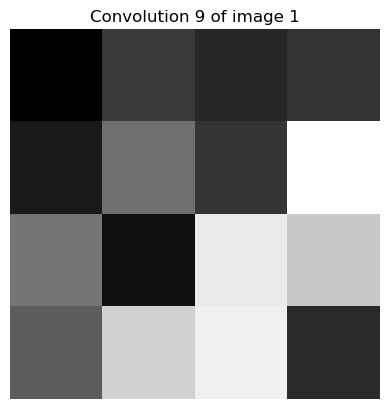

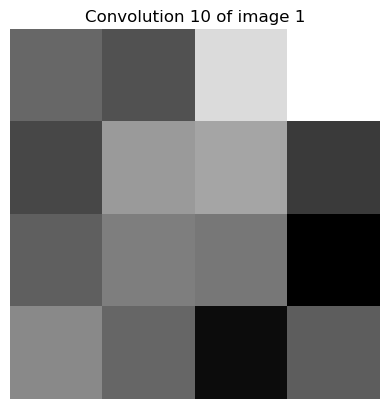

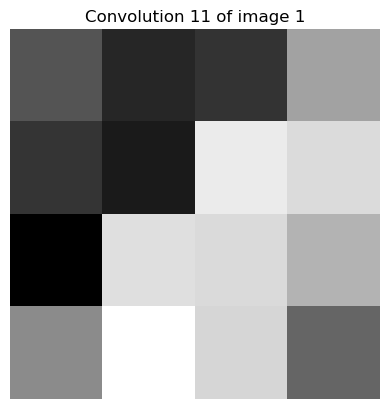

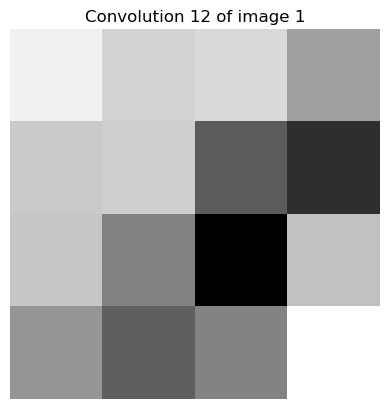

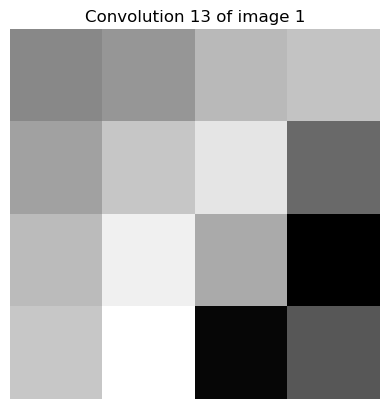

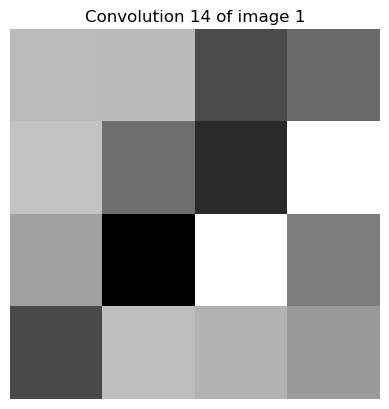

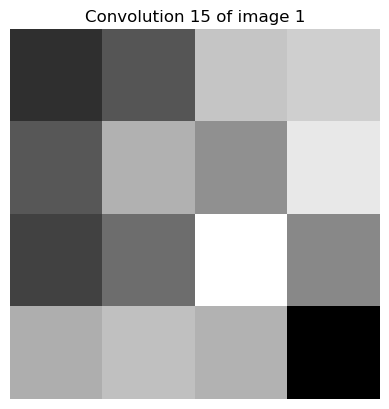

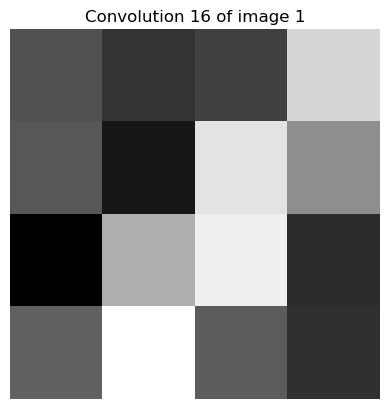

In [69]:
kernels=[sobelX,sobelY,prewittX,laplacien,laplacienPlus,blur,gaussien,sharpen]
#si je veux passer une image BGR il faut d'abord la passer en gris ou séparer les cannaux en plusieurs images
images=[X_train[0],X_train[1]]
conv1=[]
for img in images:
    conv=(conv2d([img],6,(5,5),pad_size=0))
    avr=averagePooling2d(conv,(2,2))
    conv2=conv2d(avr,16,(5,5),pad_size=0)
    avr2=averagePooling2d(conv2,(2,2))
    conv1.append(avr2)
for i in range(1):
    for m in range(len(conv1[i])):
        plt.imshow(conv1[i][m],cmap="gray")
        plt.title(f"Convolution {m+1} of image {i+1}")
        plt.axis("off")
        plt.show()

In [70]:
flat=[]
for i in range(len(conv1)):
    fla=[]
    for convs in conv1[i]:
        fla.append(convs.flatten())
    ca=np.concatenate(fla)
    flat.append(ca)

In [71]:
print(len(flat[0]))

256


In [72]:
def createRandomBias(nb_neurones):
    bias=np.random.randn(nb_neurones)
    return bias

In [73]:
def createRandomWeights(nb_inputs,nb_neurones):
    limit=np.sqrt(6/(nb_inputs+nb_neurones))
    weights=np.random.uniform(-limit,limit,size=(nb_neurones,nb_inputs))
    return weights

In [74]:
def denseLayer(inputs,nb_neurones,fonctionActivation=None,specificBias=None,specificWeights=None,returnWeightsAndBias=False,alpha=0.01):
    bias=[]
    weights=[]
    outputs=[]
    if specificBias is None:
        bias=createRandomBias(nb_neurones)
    elif len(specificBias)==nb_neurones:
        bias=specificBias
    else:
        print(f"Erreur : le nombre de biais assigné ({len(specificBias)}) n'est pas équivalent au nombre de neurones : {nb_neurones}")
    if specificWeights is None:
        weights=createRandomWeights(len(inputs),nb_neurones)
    elif len(specificWeights)==nb_neurones and len(specificWeights[0])==len(inputs):
        weights=specificWeights
    else:
        print(f"Erreur : le nombre de poids assigné n'est pas correct : {len(specificWeights)} pour {nb_neurones} neurones et {len(specificWeights[0])} pour {len(inputs)} inputs.")
    for neurone in range(nb_neurones):
        result=0
        for inpu in range(len(inputs)):
            result+=(inputs[inpu]*weights[neurone][inpu])
        result+=bias[neurone]
        if fonctionActivation=="ReLU":
            result=max(0,result)
        if fonctionActivation=="Leaky ReLU":
            if result<0:
                result=alpha*result
        if fonctionActivation=="Sigmoid":
            result=(1/(1+np.exp(-result)))
        if fonctionActivation=="Tanh":
            result=((np.exp(result)-np.exp(-result))/(np.exp(result)+np.exp(-result)))
        outputs.append(result)
    outputs=np.array(outputs)
    if fonctionActivation=="Softmax":
        exps=np.exp(outputs-np.max(outputs))
        outputs=exps/np.sum(exps)
    if returnWeightsAndBias:
        return outputs,weights,bias
    return outputs

In [75]:
test=np.random.randn(3)
print(test)
outputs=denseLayer(test,2,fonctionActivation="Leaky ReLU")
print(outputs)
outputs2=denseLayer(outputs,3,fonctionActivation="Softmax")
print(outputs2)

[ 0.35408001  0.08569298 -1.36533082]
[0.28547012 2.11805041]
[0.61885855 0.01925376 0.36188769]


In [76]:
y_train=[]
for y in range(len(ytrain)):
    yt=np.zeros(10)
    yt[ytrain[y]]=1
    y_train.append(yt)

In [77]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [78]:
outputs1,weights1,bias1=[],createRandomWeights(256,128),createRandomBias(128)
outputs2,weights2,bias2=[],createRandomWeights(128,84),createRandomBias(84)
outputs3,weights3,bias3=[],createRandomWeights(84,10),createRandomBias(10)
#256 -> 128 -> 84 -> 10
for f,fla in enumerate(flat):
    outputs1.append(denseLayer(fla,128,fonctionActivation="ReLU",specificBias=bias1,specificWeights=weights1))
    outputs2.append(denseLayer(outputs1[f],84,fonctionActivation="ReLU",specificBias=bias2,specificWeights=weights2))
    outputs3.append(denseLayer(outputs2[f],10,fonctionActivation="Softmax",specificBias=bias3,specificWeights=weights3))

print(outputs3[0])
print(outputs3[1])

[1.33135899e-05 3.62203117e-31 1.68576532e-05 3.52646124e-25
 2.28016099e-20 3.66748608e-27 9.99969828e-01 8.67588880e-10
 1.24799601e-31 3.39351658e-19]
[6.97184479e-05 2.56010792e-12 1.53311214e-02 2.17160621e-10
 5.65676745e-07 7.03393422e-04 9.83894839e-01 2.07650140e-07
 1.45527510e-07 8.22661976e-09]


In [79]:
MSE=[]
for out in range(len(outputs3)):
    MSE.append((np.sum((outputs3[out]-y_train[out])**2))/10)
print(MSE[1])

0.19681451611175424


In [ ]:
#DMSE/DWx = DMSE/DYx * DYx/DZx * DZx/DWx pour les poids entre la dernière couche et la couche de sortie
#fonction d'activation : Softmax
#on fait 84 -> 10 donc chaque output a 84 poids connectés à elle
#DMSE/Dweights3[0][0] -> pour actualier le premier poids, celui entre le premier neurone de la couche précédente et la première output.
#= DMSE/Doutputs3[0] (Doutputs3[0] = softmax(Z0)+bias3[0]) * Doutputs3[0]/DZ[0] * DZ[0]/Dweights3[0][0] Z[0] = a0*weights3[0][0]+a0*weights3[0][1]+...+bias[0], 
#a0 étant l'output du premier neurone de la couche précédente et bias3 le biais du premier neurone.
#Ainsi MSE=(1/10)*SOMME((outputs3-y_train[0])**2) = 1/10 * ((outputs3[0]-y_train[0][0])²+(outputs3[0]-y_train[0][0])²+...) donc DMSE/Doutputs3[0] = 1/10 * 2 * 1 * (outputs3[0]-y_train[0][0])
#Doutputs3[0]/DZ[0] = Dsoftmax(Z0)/DZ0 -> softmax(Z0) = exp(Z0)/SOMME0->n(exp(Zn)) Dsoftmax(Z0)/DZ0 est de la forme (U/V)' donc = (exp(Z0)*(SOMME)-exp(Z0)²)/SOMME² = exp(Z0)*(SOMME-exp(Z0))/SOMME²
#sachant que outputs3[0]=exp(Z0)/SOMME alors Dsoftmax(Z0)/DZ0= outputs3[0]*((SOMME/SOMME)-(exp(Z0)/SOMME)) = outputs3[0]*(1-outputs3[0]) = outputes3[0] - outputs3[0]**2
#enfin, DZ0/Dweights3[0][0]= D(outputs2[0]*weights3[0][0]+outputs2[0]*weights3[0][1]...)/Dweights3[0][0] = outputs2[0]
#en conclusion: DMSE/Dweights3[0][0]=1/5 * (outputs3[0]-y_train[0][0]) * (outputs3[0]-outputs3[0]**2) * outputs2[0]
#et pour actualiser weights3[0][1] : 1/5 * (outputs3[0]-y_train[0][0]) * (outputs3[0]-outputs3[0]**2) * outputs2[1] jusqu'à outputs2[83] pour weights3[0][83]
#pour weights3[1][0] : 1/5 * (outputs3[1]-y_train[0][1]) * (outputs3[1]-outputs3[1]**2) * outputs2[0] etc...
#pour weights2[0][0]: (1/5 * (outputs3[1]-y_train[0][1]) * (outputs3[1]-outputs3[1]**2)+1/5 * (outputs3[2]-y_train[0][2]) * (outputs3[2]-outputs3[2]**2)...)* Da/Dz-1
def backPropagation(outputs1,outputs2,outputs3,weights1,weights2,weights3,bias1,bias2,bias3,MSE,alpha=0.001,f1="ReLU",f2="ReLU"):
    newWeights3Grads=np.zeros(weights3.shape)
    newBias3Grads=np.zeros(bias3.shape)
    for img in range(len(outputs3)): #on parcours chaque image
        for outputs3a in range(len(outputs3[img])):
            sumBiasGrad3=0
            gradB3=(1/5)*(outputs3[img][outputs3a]-y_train[img][outputs3a])*outputs3[img][outputs3a]*(1-outputs3[img][outputs3a])
            sumBiasGrad3+=gradB3
            newBias3Grads[outputs3a]=sumBiasGrad3
            for outputs2a in range(len(outputs2[img])):
                #print(f"img : {img}/{len(images)} outputs2a : {outputs2a}/{len(outputs2[img])} outputs3a : {outputs3a}/{len(outputs3[img])}")
                gradW3=gradB3*outputs2[img][outputs2a]
                newWeights3Grads[outputs3a][outputs2a]+=gradW3
            
        for bias in newBias3Grads:
            for outputs2a in range(len(outputs2[img])):
                if f2=="ReLU":
                    "gradB2=bias*"
                
    newWeights3=weights3-alpha*newWeights3Grads/len(outputs3)
    newBias3=bias3-alpha*newBias3Grads/len(outputs3)
    return newWeights3,newBias3

def backProp(outputs1,outputs2,outputs3,weights1,weights2,weights3,bias1,bias2,bias3,MSE,alpha=0.001,f1="ReLU",f2="ReLU"):
    gradSoft=np.zeros(outputs3[0].shape[0])
    gradB3=np.zeros(outputs3[0].shape[0])
    gradW3=np.zeros(weights3.shape)
    gradWeights3=np.zeros(weights3.shape)
    gradW2=np.zeros(weights2.shape)
    gradWeights2=np.zeros(weights2.shape)
    for img in range(len(outputs3)):
        gradA2=np.zeros(outputs2[img].shape[0])
        gradMSE=(2/len(outputs3[img]))*(outputs3[img]-y_train[0])
        gradSoft=gradMSE*outputs3[img]*(1-outputs3[img])
        for out3 in range(len(outputs3[img])): #chaque neurone de sortie (10)
            for out2 in range(len(outputs2[img])): #chaque output précédent
                gradWeights3[out3][out2]=gradSoft[out3]*outputs2[img][out2]
        
        for out2 in range(len(outputs2[img])):
            for out3 in range(len(outputs3[img])):
                if f2=="ReLU":
                    if outputs2[img][out2]>0:
                        gradA2[out2]+=gradSoft[out3]*weights3[out3][out2]
                    else:
                        gradA2[out2]+=0
        
        for out2 in range(len(outputs2[img])):
            for out1 in range(len(outputs1[img])):
                gradWeights2[out2][out1]=gradA2[out2]*outputs1[img][out1]

        gradW2+=gradWeights2/len(outputs3)
        gradB2+=gradA2/len(outputs3)
        gradB3+=gradSoft/len(outputs3)
        gradW3+=gradWeights3//len(outputs3)
    return gradSoft
            

In [111]:
print(backProp(outputs1,outputs2,outputs3,weights1,weights2,weights3,bias1,bias2,bias3,MSE,alpha=0.001,f1="ReLU",f2="ReLU").shape)

(10,)


In [117]:
print(weights3.shape)

(10, 84)
